Preparing the dataset for training

float32
<dtype: 'float32'>


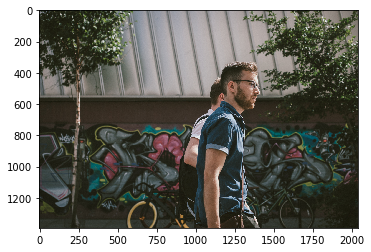

In [2]:
import scipy
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

n_epoch = 200
batch_size = 1

lr_init = 1e-4

hr_images_path = "Data\DIV2K_train_HR\DIV2K_train_HR\*"
hr_images_path = glob(hr_images_path)
hr_images_path = np.random.choice(hr_images_path, size=batch_size)

hr_images_ds = []
lr_images_ds = []

for img_path in hr_images_path:
    img = plt.imread(img_path)
    print(img.dtype)
    plt.imshow(img)
    hr_patch = tf.random_crop(img, [256, 256, 3])
    print(hr_patch.dtype)
    hr_patch = np.array(hr_patch) / 127.5 - 1
    hr_patch  = tf.image.random_flip_left_right(hr_patch)
    lr_patch  = tf.image.resize_images(hr_patch, size=[64, 64])
    hr_images_ds.append(hr_patch)
    lr_images_ds.append(lr_patch)
    

# Display the cropped image
#train_images_ds = tf.data.Dataset.from_tensor_slices((lr_images_ds, hr_images_ds))
#train_images_ds = train_images_ds.repeat(300)
#train_images_ds = train_images_ds.shuffle(128)
#train_images_ds = train_images_ds.prefetch(2048)
#train_images_ds = train_images_ds.batch(16)

#print(train_images_ds)

In [19]:
from glob import glob
import numpy as np
import tensorflow as tf
# prepare dataset function

def PREPARE_DATASET():
    hr_images_path = "Data\DIV2K_train_HR\DIV2K_train_HR\*"
    hr_images_path = glob(hr_images_path)
    
    lr_images_ds = []
    hr_images_ds = []
    
    for n in range(batch_size):
        img_path = np.random.choice(hr_images_path, size=batch_size)
        img = plt.imread(img_path)
        hr_patch = tf.random_crop(img, [256, 256, 3])
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        lr_patch = tf.image.resize_images(hr_patch, size=[64, 64, 3])
        lr_images_ds.append(lr_patch)
        hr_images_ds.append(hr_patch)
    
    return hr_images_ds, lr_images_ds

Defining the model

In [16]:
import scipy

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers import PReLU, LeakyReLU
#from keras.layers import UpSampling2D, Conv2D
#from keras.layers.convolutional import UpSamping2D, Conv2D
from keras.layers.convolutional import UpSampling2D, Conv2D

from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow.layers as tfl
import matplotlib.pyplot as plt
import numpy as np

import os
import sys


def SRGAN_GEN(input_shape):
    n0 = Input(input_shape)
    n = Conv2D(64, kernel_size=9, strides=1, padding='SAME')(n0)
    n = Activation('relu')(n)
    tmp = n
    
    # Residual blocks
    for i in range(16):
        nn = Conv2D(64, kernel_size=3, strides=1, padding='SAME')(n)
        nn = Activation('relu')(n)
        nn = BatchNormalization(momentum=0.8)(nn)
        nn = Conv2D(64, kernel_size=3, strides=1, padding='SAME')(nn)
        nn = BatchNormalization(momentum=0.8)(n)
        nn = Add()([n, nn])
        n  = nn
    
    n = Conv2D(64, kernel_size=3, strides=1, padding='SAME')(n)
    n = BatchNormalization(momentum=0.8)(n)
    n = Add()([n, nn])
    
    n = UpSampling2D(size=2)(n)
    n = Conv2D(256, kernel_size=3, strides=1, padding='SAME')(n)
    n = Activation('relu')(n)
    
    n = UpSampling2D(size=2)(n)
    n = Conv2D(256, kernel_size=3, strides=1, padding='SAME')(n)
    n = Activation('relu')(n)
    
    nn = Conv2D(3, kernel_size=9, strides=1, padding='SAME')(n)
    
    GEN = Model(inputs=n0, outputs=nn, name="SRGAN_GENERATOR")
    
    return GEN

def SRGAN_DIS(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    
    n0 = Input(input_shape)
    n = Conv2D(64, kernel_size=4, strides=1, padding='SAME')(n0)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64 * 2, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = Conv2D(64 * 4, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    n = Conv2D(64 * 8, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 16, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.2)(n)
    
    n = Conv2D(64 * 32, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 16, kernel_size=1, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 8, kernel_size=1, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    nn = BatchNormalization(momentum=0.8)(n)
    
    
    n = Conv2D(64 * 2, kernel_size=1, strides=1, padding='SAME')(nn)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 2, kernel_size=3, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 8, kernel_size=3, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Add()([n, nn])
    n = LeakyReLU(alpha=0.2)(n)
    
    no = Dense(1)(n)
    DIS = Model(inputs=n0, outputs=no, name="SRGAN_DISCRIMINATOR")
    
    return DIS


def VGG_FEATURES(input_shape):
    vgg = VGG19(weights="imagenet")
    # Set outputs to outputs of last conv. layer in block 3
    # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
    vgg.outputs = [vgg.layers[9].output]

    img = Input(input_shape)

    # Extract image features
    img_features = vgg(img)
    
    VGG_FEATURES = Model(inputs=img, outputs=img_features, name="VGG_FEATURES")
    
    return VGG_FEATURES


    

Training pipeline

In [17]:
# define input shape

# Training pipeline
def SRGAN_BUILD(input_shape):
    # read inputs
    lr_patch = Input(input_shape)
    hr_patch = Input(input_shape)
    
    # create optimizer
    optimizer = Adam(0.0002, 0.5)
    
    # building phase
    
    # use vgg feature: no training
    vgg_feature = VGG_FEATURES(input_shape)
    vgg_feature.trainable = False
    vgg_feature.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    
    # create the discriminator model
    srgan_dis = SRGAN_DIS(input_shape)
    srgan_dis.compile(loss='mse', optimizer=optimizer, metrics=['accuracy']) 
    
    # create srgan complete model
    hr_patch = Input(input_shape)
    lr_patch = Input(input_shape)
    
    srgan_gen = SRGAN_GEN(input_shape)
    pred_hr = srgan_gen(lr_patch)
    pred_features = vgg_feature(pred_hr)
    srgan_dis.trainable = False
    real = srgan_dis(pred_hr)    
    srgan_complete = Model([lr_patch, hr_patch], [real, pred_features])
    srgan_complete.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=optimizer)


input_shape = (256, 256, 3)    
SRGAN_BUILD(input_shape)
#SRGAN_TRAIN(input_shape, n_epoch=100, batch_size=1)

In [34]:
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# prepare dataset function

def PREPARE_DATASET():
    hr_images_path = "Data\DIV2K_train_HR\DIV2K_train_HR\*"
    hr_images_path = glob(hr_images_path)
    
    lr_images_ds = []
    hr_images_ds = []
    
    for n in range(batch_size):
        img_path = np.random.choice(hr_images_path, size=batch_size)
        print(img_path)
        img = plt.imread(img_path)
        hr_patch = tf.random_crop(img, [256, 256, 3])
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        lr_patch = tf.image.resize_images(hr_patch, size=[64, 64, 3])
        lr_images_ds.append(lr_patch)
        hr_images_ds.append(hr_patch)
    
    return hr_images_ds, lr_images_ds

def SRGAN_TRAIN(input_shape, n_epoch, batch_size):
    # Training phase
    for n in range(n_epoch):
        print(n)
        hr_patch, lr_patch = PREPARE_DATASET();
        
        pred_hr = srgan_gen.predict(lr_patch)
    
        # Train the discriminator
        real = np.ones(batch_size)
        fake = np.zeros(batch_size) 
        dis_loss_real = srgan_dis.train_on_batch(hr_patch, real)
        dis_loss_pred = srgan_dis.train_on_batch(pred_hr, fake)
        dis_loss = 0.5 * np.add(dis_loss_real, dis_loss_pred)

        # Train generator
        real = np.ones(batch_size)
        real_features = vgg_feature.predict(hr_patch)
        srgan_loss = srgan_complete.train_on_batch([lr_patch, hr_patch], [real, real_features])
        
        if n % 10 == 0:
            printf("epoch: %s" %(epoch))

            
SRGAN_TRAIN(input_shape, n_epoch=100, batch_size=1)

0
['Data\\DIV2K_train_HR\\DIV2K_train_HR\\0349.png']


TypeError: Object does not appear to be a 8-bit string path or a Python file-like object